In [1]:
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec

init_types = ["random", "clustered"]
trials = 20
filenames = [
    f"{init_type}_{trial}" for init_type in init_types for trial in range(1, trials + 1)
]
path = "../experiments/raw_data/"
x_max = 400
y_max = 400

# fmt: off
organism_group_labels = [ "Bacteria", "Fungi", "Root-feeding Nematodes", "Bacterivorous Nematodes", "Fungivorous Nematodes", "Omnivorous Nematodes", "Fungivorous Mites", "Omnivorous Mites", "Collembolans", ]
wageningen_w_locations = [(50, 50), (50, 150), (50, 250), (50, 350), (125, 150), (175, 250), (275, 150), (225, 250), (350, 50), (350, 150), (350, 250), (350, 350)]
sys_reg_locations = [(50, 50), (50, 150), (50, 250), (50, 350), (150, 50), (150, 150), (150, 250), (150, 350), (250, 50), (250, 150), (250, 250), (250, 350),  (350, 50), (350, 150), (350, 250), (350, 350)]
# fmt: on

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use("seaborn-v0_8-whitegrid")


def rand_jitter(arr):
    if len(arr):
        stdev = 0.00025 * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev
    return arr

In [3]:
idx = 0
filename = filenames[idx]

df = pl.read_parquet(path + filename + ".parquet")
n = len(df["type"].unique())
colors = colormaps["tab10"].colors

counts_per_type = df.group_by(["type", "tick"]).agg(pl.len().alias("count"))

In [4]:
def plot_von_neumann(ax, center_x, center_y, ranges):
    # Define a list of colors that contrast well with orange
    colors_legend = [
        "blue",
        "teal",
        "darkblue",
        "darkviolet",
        "indigo",
    ]  # Adjusted colors
    colors_legend = sns.color_palette("mako", 5)

    # Plot only the outer boundary cells of the Von Neumann neighborhood
    # The outer boundary cells form a diamond shape.
    for i in reversed(range(len(ranges))):
        r = ranges[i]
        # Define the color for the current range
        color = colors_legend[i % len(colors_legend)]

        # Top and bottom edges of the diamond
        for dx in range(-r, r + 1):
            dy = r - abs(dx)
            ax.add_patch(
                patches.Rectangle(
                    (center_x + dx - 0.5, center_y + dy - 0.5),
                    1,
                    1,
                    edgecolor=color,
                    facecolor="none",
                    linewidth=3,
                )
            )
            ax.add_patch(
                patches.Rectangle(
                    (center_x + dx - 0.5, center_y - dy - 0.5),
                    1,
                    1,
                    edgecolor=color,
                    facecolor="none",
                    linewidth=3,
                )
            )

        # Left and right edges of the diamond
        for dy in range(-r + 1, r):
            dx = r - abs(dy)
            ax.add_patch(
                patches.Rectangle(
                    (center_x - dx - 0.5, center_y + dy - 0.5),
                    1,
                    1,
                    edgecolor=color,
                    facecolor="none",
                    linewidth=3,
                )
            )
            ax.add_patch(
                patches.Rectangle(
                    (center_x + dx - 0.5, center_y + dy - 0.5),
                    1,
                    1,
                    edgecolor=color,
                    facecolor="none",
                    linewidth=3,
                )
            )

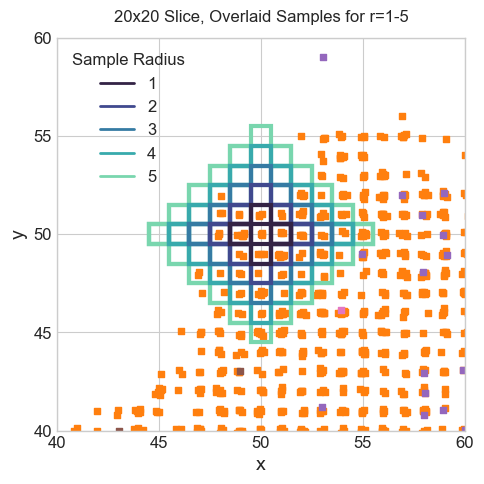

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 0

df1 = df.filter(pl.col("tick") == 266)
for t in np.unique(df1["type"]):
    subset_type = df1.filter(pl.col("type") == t)
    ax.scatter(
        rand_jitter(subset_type["x"]),
        rand_jitter(subset_type["y"]),
        color=colors[t],
        label=t,
        s=15,
        marker="s",
    )
# Add Von Neumann neighborhoods for all sample locations
for loc_x, loc_y in sys_reg_locations:
    plot_von_neumann(ax, loc_x, loc_y, range(1, 6))

ax.set_title("20x20 Slice, Overlaid Samples for r=1-5", y=1.02)
ax.set_xlabel("x")
ax.set_yticks([40, 45, 50, 55, 60])
ax.set_xticks([40, 45, 50, 55, 60])
ax.set_yticklabels([40, 45, 50, 55, 60])
ax.set_xticklabels([40, 45, 50, 55, 60])
ax.set_ylabel("y")
ax.set_xlim(sys_reg_locations[i][0] - 10, sys_reg_locations[i][0] + 10)
ax.set_ylim(sys_reg_locations[i][1] - 10, sys_reg_locations[i][1] + 10)


colors_legend = ["blue", "teal", "darkblue", "darkviolet", "indigo"]
colors_legend = sns.color_palette("mako", 5)
# Create a legend with one entry per range
legend_handles = [
    lines.Line2D([0], [0], color=colors_legend[i], lw=2) for i in range(5)
]
range_labels = [str(r) for r in range(1, 6)]
ax.legend(legend_handles, range_labels, title="Sample Radius", loc="upper left")

plt.tight_layout()
plt.savefig("6-sample-diameter.pdf")
plt.show()

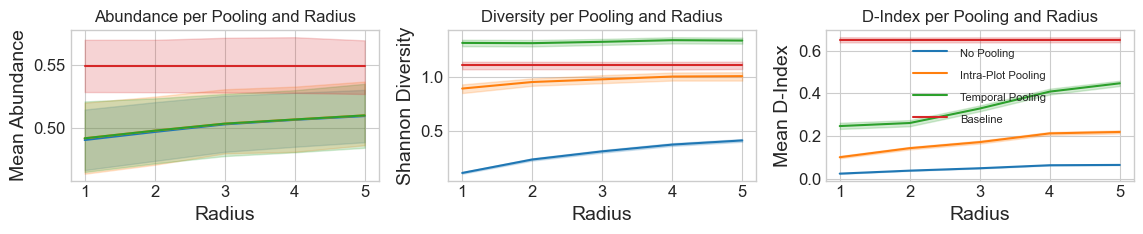

In [6]:
init_types = ["random", "clustered"]
trials = 20
filenames_reg = [
    f"{init_type}_{trial}"
    for init_type in init_types
    for trial in range(1, int(trials / 2) + 1)
]
filenames_w = [
    f"{init_type}_{trial}"
    for init_type in init_types
    for trial in range(int(trials / 2) + 1, trials + 1)
]
fig = plt.figure(figsize=(11.69, 2.5))

gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

df1 = pl.read_csv("../experiments/prep_out/estimated_abundances_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_abundances_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_n = pl.concat([df1, df2])
df_n = df_n.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean Abundance")
)
df_n = df_n.with_columns(pl.lit("No Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/estimated_abundances_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_abundances_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_i = pl.concat([df1, df2])
df_i = df_i.group_by(["filename", "r", "sample_time"]).agg(
    [pl.col(str(i)).mean().alias(str(i)) for i in range(9)]
)

df_i = df_i.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean Abundance")
)
df_i = df_i.with_columns(pl.lit("Intra-Plot Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/estimated_abundances_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_abundances_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_t = pl.concat([df1, df2])
df_t = df_t.group_by(["filename", "r", "sample_time"]).agg(
    [pl.col(str(i)).mean().alias(str(i)) for i in range(9)]
)

df_t = df_t.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean Abundance")
)
df_t = df_t.with_columns(pl.lit("Temporal Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/baseline_abundances.csv")
df1 = df1.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean Abundance")
)
dfs = [df1.with_columns(pl.lit(c).alias("r")) for c in [1, 2, 3, 4, 5]]
df1 = pl.concat(dfs, how="vertical")
df1 = df1.with_columns(pl.lit("Baseline").alias("Pooling"))

df = pl.concat([df_n, df_i, df_t, df1], how="diagonal_relaxed")

g = sns.lineplot(
    x="r", y="Mean Abundance", hue="Pooling", data=df, ax=ax1, legend=False
)
g.set_xlabel("Radius")
g.set_xticks([1, 2, 3, 4, 5])
ax1.set_title("Abundance per Pooling and Radius")

df1 = pl.read_csv("../experiments/prep_out/estimated_diversity_indices_sample_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_diversity_indices_sample_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_n = pl.concat([df1, df2])
df_n = df_n.with_columns(pl.lit("No Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/estimated_diversity_indices_plot_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_diversity_indices_plot_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_i = pl.concat([df1, df2])
df_i = df_i.with_columns(pl.lit("Intra-Plot Pooling").alias("Pooling"))

df1 = pl.read_csv(
    "../experiments/prep_out/estimated_diversity_indices_temporal_reg.csv"
)
df2 = pl.read_csv("../experiments/prep_out/estimated_diversity_indices_temporal_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_t = pl.concat([df1, df2])
df_t = df_t.with_columns(pl.lit("Temporal Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/baseline_diversity_indices.csv")
dfs = [df1.with_columns(pl.lit(c).alias("r")) for c in [1, 2, 3, 4, 5]]
df1 = pl.concat(dfs, how="vertical")
df1 = df1.with_columns(pl.lit("Baseline").alias("Pooling"))

df = pl.concat([df_n, df_i, df_t, df1], how="diagonal_relaxed")

g = sns.lineplot(x="r", y="shannon", hue="Pooling", data=df, ax=ax2, legend=False)
g.set_xlabel("Radius")
g.set_ylabel("Shannon Diversity")
g.set_xticks([1, 2, 3, 4, 5])
ax2.set_title("Diversity per Pooling and Radius")


df1 = pl.read_csv("../experiments/prep_out/estimated_d_index_sample_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_d_index_sample_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_n = pl.concat([df1, df2])
df_n = df_n.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean D-Index")
)
df_n = df_n.with_columns(pl.lit("No Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/estimated_d_index_plot_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_d_index_plot_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_i = pl.concat([df1, df2])
df_i = df_i.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean D-Index")
)
df_i = df_i.with_columns(pl.lit("Intra-Plot Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/estimated_d_index_temporal_reg.csv")
df2 = pl.read_csv("../experiments/prep_out/estimated_d_index_temporal_w.csv")
df1 = df1.filter(df1["filename"].is_in(filenames_reg))
df2 = df2.filter(df2["filename"].is_in(filenames_w))

df_t = pl.concat([df1, df2])
df_t = df_t.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean D-Index")
)
df_t = df_t.with_columns(pl.lit("Temporal Pooling").alias("Pooling"))

df1 = pl.read_csv("../experiments/prep_out/baseline_d_index.csv")
df1 = df1.with_columns(
    pl.mean_horizontal(
        [pl.col(c) for c in ["0", "1", "2", "3", "4", "5", "6", "7", "8"]]
    ).alias("Mean D-Index")
)
dfs = [df1.with_columns(pl.lit(c).alias("r")) for c in [1, 2, 3, 4, 5]]
df1 = pl.concat(dfs, how="vertical")
df1 = df1.with_columns(pl.lit("Baseline").alias("Pooling"))

df = pl.concat([df_n, df_i, df_t, df1], how="diagonal_relaxed")

g = sns.lineplot(x="r", y="Mean D-Index", hue="Pooling", data=df, ax=ax3)
g.set_xlabel("Radius")
g.set_xticks([1, 2, 3, 4, 5])
g.legend_.set_title("")
new_labels = ["No Pooling", "Intra-Plot Pooling", "Temporal Pooling", "Baseline"]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    t.set_fontsize("8")
ax3.set_title("D-Index per Pooling and Radius")


plt.tight_layout()
plt.savefig("6-actual-estimates.pdf", format="pdf", bbox_inches="tight")
plt.show()

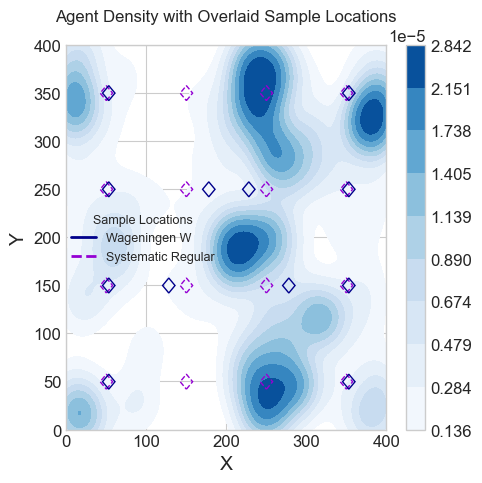

In [7]:
df = pl.read_parquet(path + filename + ".parquet")
df1 = df.filter(pl.col("tick") == 400)


def plot_von_neumann(ax, center_x, center_y, r, color, linestyle):
    # Top and bottom edges
    ax.add_patch(
        patches.Rectangle(
            (center_x + 0.25, center_y - 8),
            11,
            11,
            angle=45,
            edgecolor=color,
            facecolor="none",
            linewidth=1,
            linestyle=linestyle,
        )
    )


# Create the heatmap for agent density
plt.figure(figsize=(5, 5))
ax = plt.gca()
# Plot the density heatmap
sns.kdeplot(data=df1, x="x", y="y", cmap="Blues", fill=True, ax=ax, cbar=True)

# Overlay Systematic Regular Von Neumann neighborhoods with radius 5
for x, y in sys_reg_locations:
    plot_von_neumann(
        ax, x, y, r=5, color="darkviolet", linestyle="--"
    )  # Red dashed lines for Systematic Regular grid

# Overlay Wageningen W Von Neumann neighborhoods with radius 5
for x, y in wageningen_w_locations:
    plot_von_neumann(
        ax, x + 3, y, r=5, color="darkblue", linestyle="-"
    )  # Green solid lines for Wageningen W grid

# Set plot limits and labels
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Agent Density with Overlaid Sample Locations", y=1.04)

legend_handles = [
    lines.Line2D([0], [0], color="darkblue", lw=2, linestyle="-"),
    lines.Line2D([0], [0], color="darkviolet", lw=2, linestyle="--"),
]
range_labels = ["Wageningen W", "Systematic Regular"]
ax.legend(
    legend_handles,
    range_labels,
    title="Sample Locations",
    loc=(0, 0.42),
    prop={"size": 9},
    title_fontsize=9,
)

# Show plot
plt.tight_layout()
plt.savefig("6-sampling-locs.pdf", format="pdf", bbox_inches="tight")
plt.savefig("6-sampling-locs.png", format="png", bbox_inches="tight")
plt.show()

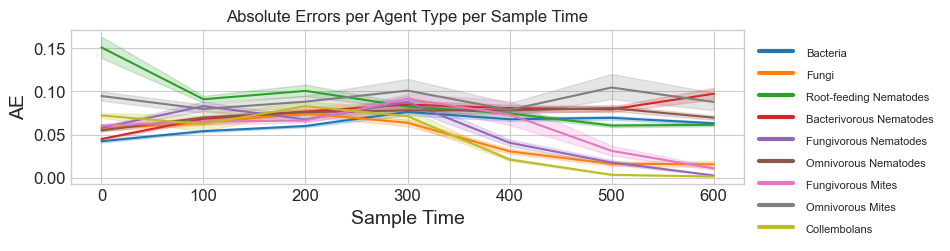

In [8]:
df1 = pl.read_csv("../experiments/analysis_out/abundances_sample_w_type.csv")
df2 = pl.read_csv("../experiments/analysis_out/abundances_sample_reg_type.csv")

df1 = df1.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df2 = df2.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)

df1 = df1.with_columns(pl.lit("w").alias("sampling_strat"))
df2 = df2.with_columns(pl.lit("reg").alias("sampling_strat"))

df_combined = pl.concat([df1, df2])
df_combined = df_combined.with_columns(
    (pl.col("distribution") + pl.col("sampling_strat")).alias("setup")
)

fig = plt.figure(figsize=(8.69, 2))

g = sns.lineplot(
    x="sample_time",
    y="ae",
    hue="type_id",
    palette=sns.color_palette("tab10")[:9],
    data=df_combined,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel("Sample Time")
g.set_ylabel("AE")
for lh in g.legend_.legend_handles:
    lh.set_linewidth("3")
g.legend_.set_title("")

for t, l in zip(g.legend_.texts, organism_group_labels):
    t.set_text(l)
    t.set_fontsize("8")
g.set_title("Absolute Errors per Agent Type per Sample Time")
plt.savefig("6-sample_time.pdf", format="pdf", bbox_inches="tight")

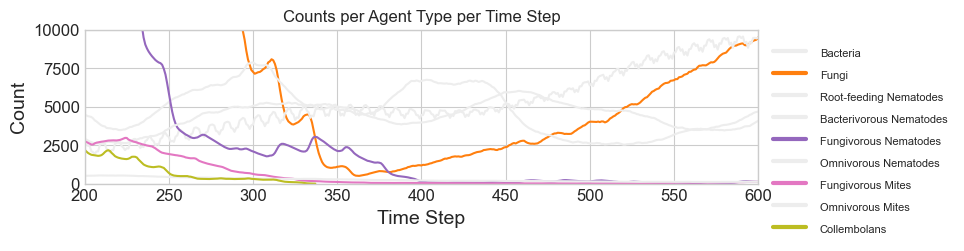

In [9]:
df = pl.read_parquet(path + "clustered_1.parquet")
fig = plt.figure(figsize=(8.69, 2))
cp = [
    (0.9295040369088812, 0.9295040369088812, 0.9295040369088812),
    (1.0, 0.4980392156862745, 0.054901960784313725),
    (0.9295040369088812, 0.9295040369088812, 0.9295040369088812),
    (0.9295040369088812, 0.9295040369088812, 0.9295040369088812),
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
    (0.9295040369088812, 0.9295040369088812, 0.9295040369088812),
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    (0.9295040369088812, 0.9295040369088812, 0.9295040369088812),
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
]


g = sns.lineplot(
    x="tick", y="len", hue="type", palette=cp, data=df.group_by(["type", "tick"]).len()
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel("Time Step")
g.set_ylabel("Count")
g.set_ybound(0, 10000)
for lh in g.legend_.legend_handles:
    lh.set_linewidth("3")
g.legend_.set_title("")

for t, l in zip(g.legend_.texts, organism_group_labels):
    t.set_text(l)
    t.set_fontsize("8")
g.set_xbound(200, 600)
g.set_title("Counts per Agent Type per Time Step")
plt.savefig("6-sample_counts.pdf", format="pdf", bbox_inches="tight")

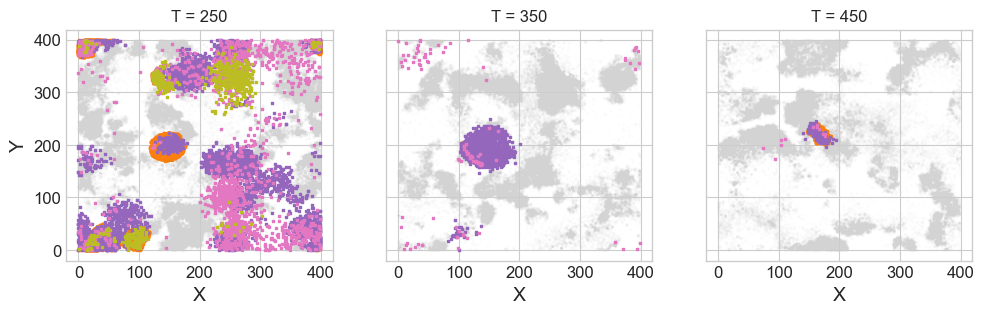

In [10]:
colors = colormaps["tab10"].colors
df = pl.read_parquet(path + "clustered_1.parquet")
fig, ax = plt.subplots(1, 3, figsize=(11.69, 3))

df1 = df.filter(pl.col("tick") == 250)
df2 = df.filter(pl.col("tick") == 350)
df3 = df.filter(pl.col("tick") == 450)

for t in np.unique(df1["type"]):
    subset_type = df1.filter(pl.col("type") == t)
    if t in [1, 4, 6, 8]:
        ax[0].scatter(
            rand_jitter(subset_type["x"]),
            rand_jitter(subset_type["y"]),
            color=colors[t],
            label=t,
            s=1,
            marker="s",
        )
    else:
        ax[0].scatter(
            rand_jitter(subset_type["x"]),
            rand_jitter(subset_type["y"]),
            color="lightgrey",
            label=t,
            s=1,
            marker="s",
            alpha=0.005,
        )
ax[0].set_title("T = 250")
ax[0].set_xlabel("X")
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_ylabel("Y")

for t in np.unique(df2["type"]):
    subset_type = df2.filter(pl.col("type") == t)
    if t in [1, 4, 6, 8]:
        ax[1].scatter(
            rand_jitter(subset_type["x"]),
            rand_jitter(subset_type["y"]),
            color=colors[t],
            label=t,
            s=1,
            marker="s",
        )
    else:
        ax[1].scatter(
            rand_jitter(subset_type["x"]),
            rand_jitter(subset_type["y"]),
            color="lightgrey",
            label=t,
            s=1,
            marker="s",
            alpha=0.005,
        )
ax[1].set_title("T = 350")
ax[1].set_xlabel("X")
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_ylabel("")
ax[1].set_yticklabels([])

for t in np.unique(df3["type"]):
    subset_type = df3.filter(pl.col("type") == t)
    if t in [1, 4, 6, 8]:
        ax[2].scatter(
            rand_jitter(subset_type["x"]),
            rand_jitter(subset_type["y"]),
            color=colors[t],
            label=t,
            s=1,
            marker="s",
        )
    else:
        ax[2].scatter(
            rand_jitter(subset_type["x"]),
            rand_jitter(subset_type["y"]),
            color="lightgrey",
            label=t,
            s=1,
            marker="s",
            alpha=0.005,
        )
ax[2].set_title("T = 450")
ax[2].set_xlabel("X")
ax[2].set_xticks([0, 100, 200, 300, 400])
ax[2].set_ylabel("")
ax[2].set_yticklabels([])

plt.savefig("6-sample-time-hms.pdf", format="pdf", bbox_inches="tight")
plt.savefig("6-sample-time-hms.png", format="png", bbox_inches="tight")

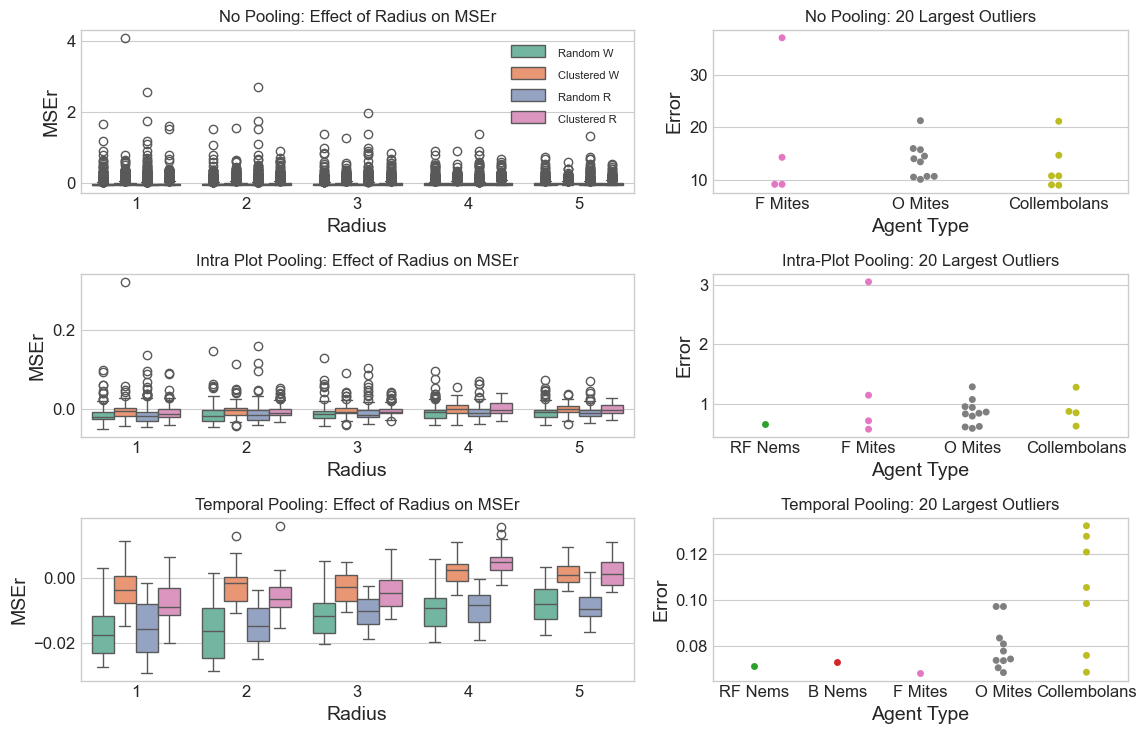

In [11]:
df1 = pl.read_csv("../experiments/analysis_out/abundances_sample_w.csv")
df1 = df1.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df1 = df1.with_columns(pl.lit("w").alias("sampling_strat"))

df2 = pl.read_csv("../experiments/analysis_out/abundances_sample_reg.csv")
df2 = df2.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df2 = df2.with_columns(pl.lit("reg").alias("sampling_strat"))
# Combine df1 and df2 into a single DataFrame
df_combined = pl.concat([df1, df2])
df_combined = df_combined.with_columns(
    (pl.col("distribution") + pl.col("sampling_strat")).alias("setup")
)

df1 = pl.read_csv("../experiments/analysis_out/abundances_plot_w.csv")
df1 = df1.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df1 = df1.with_columns(pl.lit("w").alias("sampling_strat"))
df2 = pl.read_csv("../experiments/analysis_out/abundances_plot_reg.csv")
df2 = df2.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df2 = df2.with_columns(pl.lit("reg").alias("sampling_strat"))
# Combine df1 and df2 into a single DataFrame
df_combined_2 = pl.concat([df1, df2])
df_combined_2 = df_combined_2.with_columns(
    (pl.col("distribution") + pl.col("sampling_strat")).alias("setup")
)

df1 = pl.read_csv("../experiments/analysis_out/abundances_temporal_w.csv")
df1 = df1.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df1 = df1.with_columns(pl.lit("w").alias("sampling_strat"))
df2 = pl.read_csv("../experiments/analysis_out/abundances_temporal_reg.csv")
df2 = df2.with_columns(
    pl.when(pl.col("filename").str.contains("random"))
    .then(pl.lit("random"))
    .otherwise(pl.lit("clustered"))
    .alias("distribution")
)
df2 = df2.with_columns(pl.lit("reg").alias("sampling_strat"))
# Combine df1 and df2 into a single DataFrame
df_combined_3 = pl.concat([df1, df2])
df_combined_3 = df_combined_3.with_columns(
    (pl.col("distribution") + pl.col("sampling_strat")).alias("setup")
)

fig = plt.figure(figsize=(11.69, 7.5))

gs = GridSpec(3, 2, width_ratios=[4, 3], height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])

# Plot [mae, w]
g = sns.boxplot(
    x="r",
    y="mser",
    hue="setup",
    palette=sns.color_palette("Set2")[:4],
    data=df_combined,
    ax=ax1,
    legend=True,
)
ax1.set_title("No Pooling: Effect of Radius on MSEr")
ax1.set_xlabel("Radius")
ax1.set_ylabel("MSEr")
# ax1.set_ybound(0, 5)
g.legend_.set_title("")
new_labels = ["Random W", "Clustered W", "Random R", "Clustered R"]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    t.set_fontsize("8")


df1 = pl.read_csv("../experiments/analysis_out/abundances_sample_w_type.csv")
df2 = pl.read_csv("../experiments/analysis_out/abundances_sample_reg_type.csv")
df = pl.concat([df1, df2])
data = df.top_k(20, by="ae")
g = sns.swarmplot(
    x="type_id",
    y="ae",
    hue="type_id",
    palette=[sns.color_palette("tab10")[i] for i in [6, 7, 8]],
    data=data,
    ax=ax2,
    legend=False,
)
ax2.set_title("No Pooling: 20 Largest Outliers")
ax2.set_xlabel("Agent Type")
ax2.set_ylabel("Error")
ax2.set_xticks(["6", "7", "8"])
ax2.set_xticklabels(["F Mites", "O Mites", "Collembolans"])

# Plot [mae, w]
sns.boxplot(
    x="r",
    y="mser",
    hue="setup",
    palette=sns.color_palette("Set2")[:4],
    data=df_combined_2,
    ax=ax3,
    legend=False,
)
ax3.set_title("Intra Plot Pooling: Effect of Radius on MSEr")
ax3.set_xlabel("Radius")
ax3.set_ylabel("MSEr")

df1 = pl.read_csv("../experiments/analysis_out/abundances_plot_w_type.csv")
df2 = pl.read_csv("../experiments/analysis_out/abundances_plot_reg_type.csv")
df = pl.concat([df1, df2])
data = df.top_k(20, by="ae")
g = sns.swarmplot(
    x="type_id",
    y="ae",
    hue="type_id",
    palette=[sns.color_palette("tab10")[i] for i in [2, 6, 7, 8]],
    data=data,
    ax=ax4,
    legend=False,
)
ax4.set_title("Intra-Plot Pooling: 20 Largest Outliers")
ax4.set_xlabel("Agent Type")
ax4.set_ylabel("Error")
ax4.set_xticks(["2", "6", "7", "8"])
ax4.set_xticklabels(["RF Nems", "F Mites", "O Mites", "Collembolans"])

# Plot [mae, w]
sns.boxplot(
    x="r",
    y="mser",
    hue="setup",
    palette=sns.color_palette("Set2")[:4],
    data=df_combined_3,
    ax=ax5,
    legend=False,
)
ax5.set_title("Temporal Pooling: Effect of Radius on MSEr")
ax5.set_xlabel("Radius")
ax5.set_ylabel("MSEr")

df1 = pl.read_csv("../experiments/analysis_out/abundances_temporal_w_type.csv")
df2 = pl.read_csv("../experiments/analysis_out/abundances_temporal_reg_type.csv")
df = pl.concat([df1, df2])
data = df.top_k(20, by="ae")
g = sns.swarmplot(
    x="type_id",
    y="ae",
    hue="type_id",
    palette=[sns.color_palette("tab10")[i] for i in [2, 3, 6, 7, 8]],
    data=data,
    ax=ax6,
    legend=False,
)
ax6.set_title("Temporal Pooling: 20 Largest Outliers")
ax6.set_xlabel("Agent Type")
ax6.set_ylabel("Error")
ax6.set_xticks(["2", "3", "6", "7", "8"])
ax6.set_xticklabels(["RF Nems", "B Nems", "F Mites", "O Mites", "Collembolans"])

# Adjust layout to make sure plots are neatly arranged
plt.tight_layout()
plt.savefig("6-ab-outliers.pdf", format="pdf", bbox_inches="tight")
plt.savefig("6-ab-outliers.png", format="png", bbox_inches="tight")
plt.show()